## Image segmentation with CamVid

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Data/"
base_dir = root_dir + 'fastai-v3/'

In [0]:
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [12]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_07200.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03150.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06900.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_009780_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03450_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03720_P.png')]

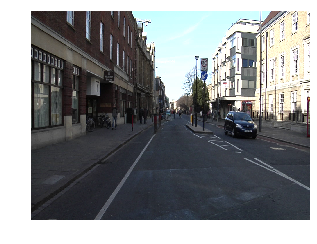

In [13]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

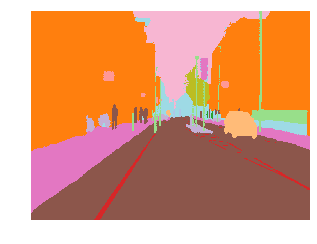

In [14]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [15]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [16]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [17]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

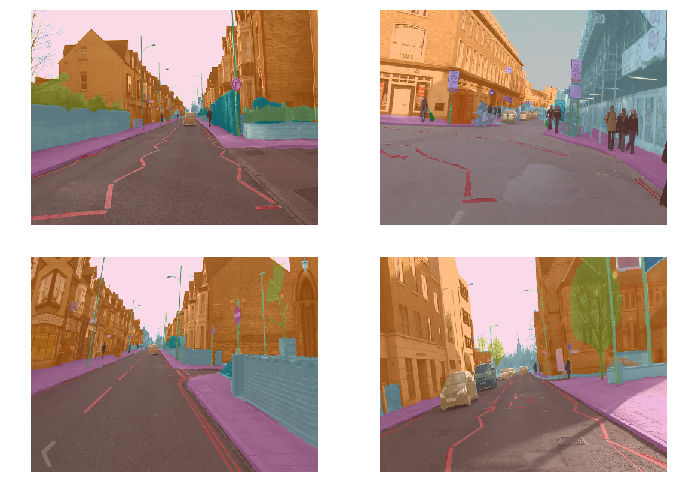

In [22]:
data.show_batch(2, figsize=(10,7))

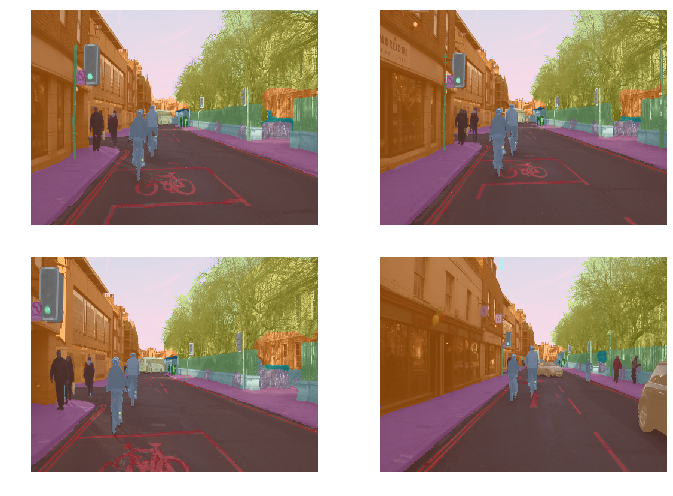

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [27]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 100875848.06it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


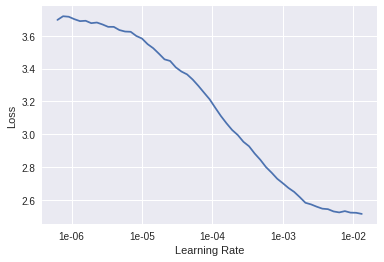

In [28]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.153229,0.846514,0.798684,03:40
1,0.828119,0.646791,0.834018,03:30
2,0.696042,0.544194,0.857007,03:30
3,0.666805,0.518744,0.864108,03:30
4,0.601002,0.459780,0.878170,03:29
5,0.600236,0.462777,0.871018,03:29
6,0.564049,0.493176,0.861449,03:29
7,0.549527,0.487594,0.873596,03:24
8,0.523314,0.401279,0.886694,03:23
9,0.452455,0.344874,0.895712,03:24


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

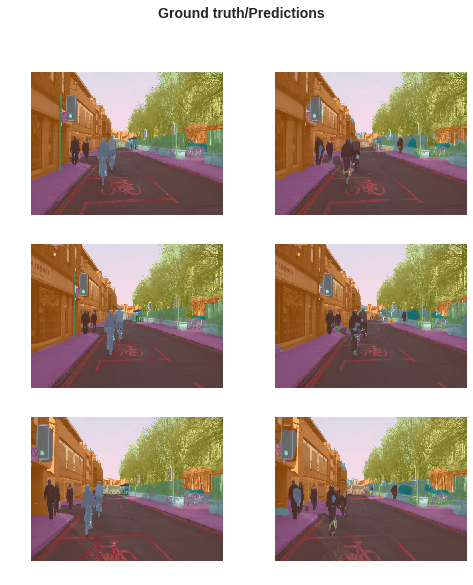

In [31]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [34]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.378432,0.331363,0.900304,03:32
1,0.369257,0.321997,0.903136,03:32
2,0.361558,0.319543,0.907098,03:32
3,0.346937,0.319338,0.906951,03:31
4,0.338093,0.318520,0.905965,03:31
5,0.335474,0.291861,0.915544,03:31
6,0.323250,0.284321,0.917220,03:32
7,0.324368,0.294644,0.917770,03:32
8,0.310648,0.287281,0.918161,03:32
9,0.293078,0.270817,0.924307,03:31


In [0]:
learn.save(base_dir + 'camvid-stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [18]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 11430MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load(base_dir + 'camvid-stage-2');

In [27]:
lr_find(learn)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

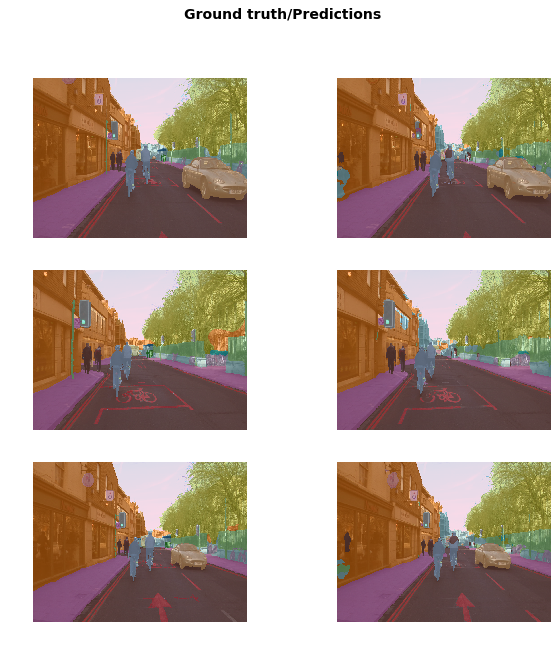

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## fin